## Problem 7.19


The lagrange polynomials of degree $n$ are described by their control points $\xi_i$ , in this case GLL points, as 
\begin{equation*}
\ell_i^n (\xi) =  \prod_{\substack{j=0\\j \neq i}}^{n} \frac{\xi - \xi_j}{\xi_i - \xi_j} \quad. 
\end{equation*}

Using the product rule the derivative is then 
\begin{equation*}
\ell'{}^n_i(\xi) = \sum_{\substack{j=0\\j \neq i}}^{n} \left[  \frac{1}{\xi_i - \xi_j} \prod_{\substack{m=0\\m \neq (i,j)}}^{n} \frac{\xi - \xi_m}{\xi_i - \xi_m} \right] \quad. 
\end{equation*}

An alternative formula for the derivative at the GLL points is given in [Canuto et al 2006, Eqn. 2.3.28](https://link.springer.com/book/10.1007/978-3-540-30726-6) in terms of Lagrange polynomials of degree $n$, $P_n$: 

\begin{equation*}
\ell_i'(\xi_j) = 
\begin{cases} 
\frac{P_n(\xi_i)}{P_n(\xi_j)(\xi_i - \xi_j)} \:, & i \ne j \\ 
-\frac{n}{4}(n+1) \:, & i = j = 0 \\ 
 \frac{n}{4}(n+1) \:, & i = j = n \\ 
 0 \:, & \text{otherwise} 
\end{cases}
\end{equation*}

To evaluate the function at GLL points specifically, we will need a function to compute the GLL points for a specific $n$ value. This function, copied from Problem 7.17 is in the cell below.

In [1]:
import scipy.special as ss 
import numpy as np 
from copy import copy
import matplotlib.pyplot as plt


def gll(N, Nsegs=100): 
    # This function is the solution to 7.17. 
    # It is not the most efficient way to compute GLL points,
    # but it works!
    nroots  = n + 1              # Number of roots
    roots   = np.zeros(nroots)   # Array to hold all the roots
    leg_n   = ss.legendre(n)    # P_n  
    leg_n_1 = ss.legendre(n-1)  # P_{n-1}

    def compute_functional(xi, n, lnm1, ln):
        return n * (lnm1(xi) - xi * ln(xi))
    
    # End points 
    roots[0]   = -1
    roots[-1]  =  1
    nrts_found =  2

    if nroots > 3:
        xi_end = 0.99999
        if n%2==0:
            xi_start = 0.00001
            nrts_found += 1
        else:
            xi_start = 0.0
        segments = np.linspace(xi_start, xi_end, Nsegs)
        fseg = compute_functional(segments, n, leg_n_1, leg_n)
        # Index in the 'roots' array to store the root
        idx = int(nroots / 2) + nroots%2 
        # Loop through each segment and test if root lies within
        for iseg in range(Nsegs-1):
            if fseg[iseg] == 0:
                # Root found exactly here
                error = 0
                nrts_found += 1
            elif fseg[iseg+1] == 0:
                # Root found exactly here
                error = 0
                nrts_found += 1
            elif fseg[iseg] * fseg[iseg+1] < 0:
                # There is a change in sign between the two values:
                # Start with the current edge xi positions of the 'segment'
                a = segments[iseg]
                b = segments[iseg+1]
                error = 999
                while np.abs(error) > 1e-9:
                    grad =  compute_functional(b, n, leg_n_1, leg_n) \
                          - compute_functional(a, n, leg_n_1, leg_n)
                    this_root = a + (b-a)/2
                    error    =  compute_functional(this_root, n, leg_n_1, leg_n)
                    if error !=0:
                        if grad*error > 0:
                            b = copy(this_root)
                        else:
                            a = copy(this_root)
                roots[idx] = this_root
                idx += 1
                nrts_found+=2
                
        for irt in range(1, int(n/2) + n%2):
            i1 = int(nroots/2) -irt
            i2 = int(nroots/2) +irt  - n%2 
            roots[i1] = -roots[i2]
        return roots 
    

def lagrange(N, a, x, GLL):
    # Computes a'th Lagrange polynomial of degree N at points x
    # using control points specified in GLL array
    poly = 1
    for j in range(0, N+1):
        if j != a:
            poly = poly * ((x - GLL[j]) / (GLL[a] - GLL[j]))
    return poly

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Now let us compute the derivatives using this product rule, and compare it against a finite-difference approach and the formula by Canuto et al 2006, to ensure consistency.

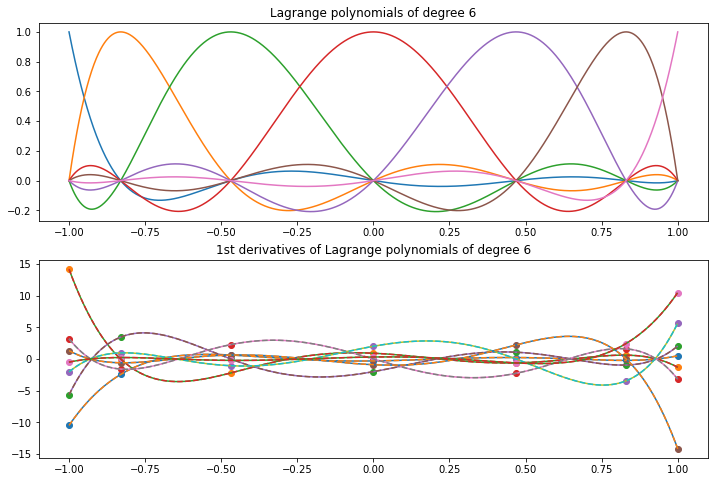

In [2]:
# Compute the Lagrange polynomials for n 
n = 6

# Compute the n+1 GLL points
gllpts = gll(n)

# We will plot the Lagrange polynomials and their derivatives
fig, ax = plt.subplots(2, figsize=(12,8))

# Define domain
x = np.linspace(-1, 1, 1000)

# Loop over the n+1 polynomials
for i in range(n+1): 
    lag = lagrange(n, i, x, gllpts)
    
    # Plot lagrange polynomials as sanity check
    ax[0].plot(x, lag)

    
    # Compute the derivative as a finite difference
    fd = (lag[2:] - lag[:-2])/(x[2]-x[0])
    ax[1].plot(x[1:-1], fd)
    
    
    # Compute the derivative with Product rule formula 
    sum = x*0 
    for j in range(n+1):
        if j!=i: 
            prod = 1 + np.zeros(len(x)) 
            for m in range(n+1): 
                if m != i and m != j: 
                    prod *= (x - gllpts[m])/(gllpts[i] - gllpts[m])
            sum += (1/(gllpts[i] - gllpts[j])) * prod  
    # Plot product rule version 
    ax[1].plot(x, sum, '--')

    
# Computing specifically at GLL points: 
# Using method in Canuto et al 2006
# Loop over polynomials
for i in range(n+1):
    # Loop over GLL points 
    derivs = np.zeros(n+1)
    
    leg_n = ss.legendre(n)
    for j in range(n+1):
        if i == 0 and j == 0:
            derivs[j] = -(n+1)*n/4
        elif i == n and j == n: 
            derivs[j] = (n+1)*n/4
        elif i != j:  
            derivs[j] = leg_n(gllpts[j]) / ( leg_n(gllpts[i]) * (gllpts[j]-gllpts[i]) ) 
        else: 
            derivs[j] = 0 
    # Plot
    ax[1].scatter(gllpts, derivs, marker='o')
    
    
# Cosmetics
ax[0].set_title(f'Lagrange polynomials of degree {n}');
ax[1].set_title(f'1st derivatives of Lagrange polynomials of degree {n}');